In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = r'C:\Users\Lenovo\Desktop\classes_equal'  

# Split the dataset into training and validation
batch_size = 30 #tweak 
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"  
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 420 files belonging to 3 classes.
Using 336 files for training.
Found 420 files belonging to 3 classes.
Using 84 files for validation.
Classes: ['negative', 'tb', 'tb-hiv']


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)# reduce lr by 0.5 whe no improvement on val data for 3 epochs


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))#has to be same size as the preprocessing
base_model.trainable = False  # freeze base model
#feature map
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)#changes performance 
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)#
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])#

model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - accuracy: 0.3617 - loss: 8.6461 - val_accuracy: 0.6071 - val_loss: 1.6802
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.4506 - loss: 5.9395 - val_accuracy: 0.8214 - val_loss: 0.4966
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.5623 - loss: 3.1105 - val_accuracy: 0.7857 - val_loss: 0.5063
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.6319 - loss: 2.4276 - val_accuracy: 0.6548 - val_loss: 0.7949
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.5574 - loss: 2.6897 - val_accuracy: 0.7619 - val_loss: 0.6122
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.6331 - loss: 1.8211 - val_accuracy: 0.7738 - val_loss: 0.6008
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.6134 - loss: 1.9024 - val_accuracy: 0.7976 - val_loss: 0.4993
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.6762 - loss: 1.3577 - val_accuracy: 0.7619 - val_loss:

In [10]:
print(base_model.layers)

[<InputLayer name=input_layer, built=True>, <Conv2D name=block1_conv1, built=True>, <Conv2D name=block1_conv2, built=True>, <MaxPooling2D name=block1_pool, built=True>, <Conv2D name=block2_conv1, built=True>, <Conv2D name=block2_conv2, built=True>, <MaxPooling2D name=block2_pool, built=True>, <Conv2D name=block3_conv1, built=True>, <Conv2D name=block3_conv2, built=True>, <Conv2D name=block3_conv3, built=True>, <MaxPooling2D name=block3_pool, built=True>, <Conv2D name=block4_conv1, built=True>, <Conv2D name=block4_conv2, built=True>, <Conv2D name=block4_conv3, built=True>, <MaxPooling2D name=block4_pool, built=True>, <Conv2D name=block5_conv1, built=True>, <Conv2D name=block5_conv2, built=True>, <Conv2D name=block5_conv3, built=True>, <MaxPooling2D name=block5_pool, built=True>]


In [4]:
from sklearn.metrics import classification_report
import numpy as np

# Extract true and predicted labels
y_true_labels = []
y_pred_labels = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true_labels.extend(np.argmax(labels.numpy(), axis=1))   # convert one-hot to class index
    y_pred_labels.extend(np.argmax(preds, axis=1))

class_names = train_ds.class_names

report = classification_report(
    y_true_labels, 
    y_pred_labels, 
    target_names=class_names
)
print(report)






1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

    negative       0.74      0.94      0.83        33
          tb       0.96      1.00      0.98        23
      tb-hiv       0.89      0.57      0.70        28

    accuracy                           0.83        84
   macro avg       0.86      0.84      0.83        84
weighted avg       0.85      0.83      0.82        84



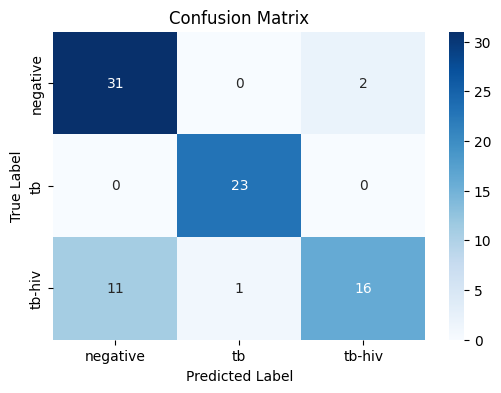

In [5]:
%pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels
y_true = np.array(y_true_labels)
y_pred = np.array(y_pred_labels)

# Get confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [3]:
import numpy as np
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical

# Get true and predicted labels from the validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
print("AUC (One-vs-Rest):", auc)

# Optional: calculate confidence intervals using bootstrapping
def compute_ci(y_true, y_pred, n_bootstraps=1000):
    scores = []
    rng = np.random.RandomState(seed=42)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(np.argmax(y_true[indices], axis=1))) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices], multi_class='ovr')
        scores.append(score)
    sorted_scores = np.sort(scores)
    return sorted_scores[int(0.025 * len(sorted_scores))], sorted_scores[int(0.975 * len(sorted_scores))]

ci_lower, ci_upper = compute_ci(y_true, y_pred)
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
AUC (One-vs-Rest): 0.9385675170087474
95% Confidence Interval: [0.8932, 0.9723]


In [ ]:
y_pred_classes = np.argmax(y_pred_probs, axis=1)

In [ ]:
# Install the required package
#%pip install opencv-python

import cv2
import matplotlib.pyplot as plt

def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    return np.expand_dims(array, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        output = predictions[:, pred_index]

    grads = tape.gradient(output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
img_path = r"C:\Users\Lenovo\Desktop\classes_equal\tb-hiv\00001-1c3b38bd.png"
img_array = get_img_array(img_path, size=(224, 224))
heatmap = make_gradcam_heatmap(img_array, model, 'block5_conv3')
display_gradcam(img_path, heatmap)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


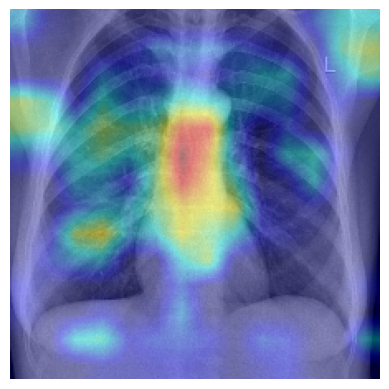